In [22]:
import MDAnalysis
import numpy as np
from DEERPREdict.PRE import PREpredict
from DEERPREdict.DEER import DEERpredict
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

This notebook reproduces Figure 2 Supplement 5 and 6 in "Structure and dynamics of a nanodisc by integrating NMR, SAXS and SANS experiments with molecular dynamics simulations" by Bengtsen and coworkers.

The DEER and PRE data is calculated from the MD simulation trajectory in `../molecular_dynamics_simulations/` and PDB code 2N5E using the software [DEER-PREdict](https://github.com/KULL-Centre/DEERpredict).

DEER-PREdict can be installed using `pip`:
```bash
pip install DEERPREdict
```


Contact: giulio.tesei@bio.ku.dk

Load BME weights

In [3]:
weights = np.loadtxt('../BME_reweight/BME_simulation_weights.dat',usecols=1)
weights.size

1195

Load trajectory

In [4]:
u = MDAnalysis.Universe('../molecular_dynamics_simulations/topology.pdb',
                        '../molecular_dynamics_simulations/all_simulations.xtc')
protein = u.select_atoms("segid A or segid B")
with MDAnalysis.Writer("md.xtc", protein.n_atoms) as W:
    for ts in u.trajectory[1:]:
        W.write(protein)
protein.write("md.pdb")
u = MDAnalysis.Universe('md.pdb','md.xtc')
u.trajectory.n_frames

1195

Load PDB code 2N5E

In [6]:
updb = MDAnalysis.Universe('2N5E.pdb','2N5E.xtc')
updb.trajectory.n_frames

10

### DEER predictions

In [9]:
!mkdir calcDEER

In [11]:
labels = [67,166,100,192,148,213]

DEER distance distributions from MD trajectory

In [13]:
for label in labels:
    DEER = DEERpredict(u, residues=[label, label], chains=['A', 'B'], 
            log_file='calcDEER/log', temperature=303.15)
    DEER.run(output_prefix = 'calcDEER/res')
    DEER.run(output_prefix = 'calcDEER/BMEres', load_file = 'calcDEER/res-{:d}-{:d}.hdf5'.format(label,label), 
            weights = weights)

DEER distance distributions from PDB structure

In [15]:
for label in labels:
    DEER = DEERpredict(updb, residues=[label, label], chains=['A', 'B'], 
            log_file='calcDEER/log', temperature=303.15)
    DEER.run(output_prefix = 'calcDEER/PDBres')

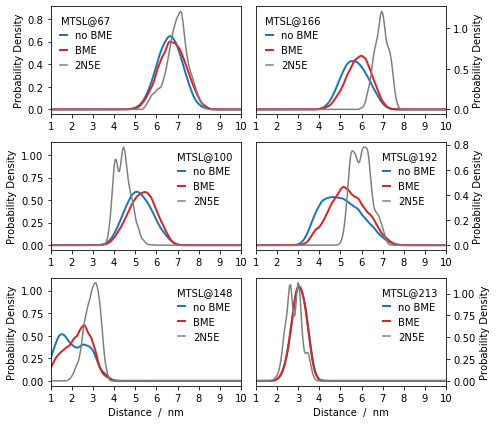

In [16]:
fig, axes = plt.subplots(3, 2, sharex=False, sharey=False, figsize=(7,6))
labels = [67,166,100,192,148,213]
for ax,label in zip(axes.flatten(),labels):

    x, y = np.loadtxt('calcDEER/res-{:d}-{:d}.dat'.format(label,label),unpack=True)
    ax.plot(x,y/np.trapz(y,x),color=plt.cm.tab10(0),ls='-',label=r'no BME',lw=2)
    
    x, y = np.loadtxt('calcDEER/BMEres-{:d}-{:d}.dat'.format(label,label),unpack=True)
    ax.plot(x,y/np.trapz(y,x),color=plt.cm.tab10(3),ls='-',label=r'BME',lw=2)
    
    x, y = np.loadtxt('calcDEER/PDBres-{:d}-{:d}.dat'.format(label,label),unpack=True)
    ax.plot(x,y/np.trapz(y,x),color=plt.cm.tab10(7),ls='-',label=r'2N5E',lw=1.5)

    ax.set_ylabel('Probability Density')
    ax.set_xlim(1,10)
    ax.legend(frameon=False,title='MTSL@{:d}'.format(label),handlelength=.7)
    ax.set_xticks(range(1,11))
    
for i in [1,3,5]:
    axes.flatten()[i].yaxis.set_label_position("right")
    axes.flatten()[i].yaxis.set_ticks_position('right')
    
axes.flatten()[-2].set_xlabel('Distance  /  nm')
axes.flatten()[-1].set_xlabel('Distance  /  nm')

plt.tight_layout(w_pad=.5)
plt.savefig('Fig2_S6.pdf')

### PRE predictions

In [17]:
!mkdir calcPRE

PRE ratios from MD trajectory

In [18]:
PRE = PREpredict(u, residue = 67, chains = ['A','A'], 
        log_file = 'calcPRE/log', temperature = 303.15, atom_selection = 'N')
PRE.run(output_prefix = 'calcPRE/res',
        tau_t = 1*1e-9, delay = 0.01, tau_c = 34*1e-09, k = 1.23e16, r_2 = 60, wh = 600)

labels = [67,166,100,192,148,213,235]
for label in labels:
    PRE = PREpredict(u, residue = label, chains = ['A','B'], 
        log_file = 'calcPRE/log', temperature = 303.15, atom_selection = 'N')
    PRE.run(output_prefix = 'calcPRE/ABres',
        tau_t = 1*1e-9, delay = 0.01, tau_c = 34*1e-09, k = 1.23e16, r_2 = 60, wh = 600)
    PRE = PREpredict(u, residue = label, chains = ['B','A'], 
        log_file = 'calcPRE/log', temperature = 303.15, atom_selection = 'N')
    PRE.run(output_prefix = 'calcPRE/BAres',
        tau_t = 1*1e-9, delay = 0.01, tau_c = 34*1e-09, k = 1.23e16, r_2 = 60, wh = 600)

BME-reweighted PRE ratios

In [19]:
PRE = PREpredict(u, residue = 67, chains = ['A','A'],
      log_file = 'calcPRE/log', temperature = 303.15, atom_selection = 'N')
PRE.run(output_prefix = 'calcPRE/BMEres', load_file = 'calcPRE/res-{:d}.pkl'.format(67),
      weights = weights, tau_t = 1*1e-9, delay = 0.01, tau_c = 34*1e-09, k = 1.23e16, r_2 = 60, wh = 600)

labels = [67,166,100,192,148,213,235]
for label in labels:
    PRE = PREpredict(u, residue = label,  
        chains = ['A','B'], log_file = 'calcPRE/log', temperature = 303.15, atom_selection = 'N')
    PRE.run(output_prefix = 'calcPRE/BMEABres', load_file = 'calcPRE/ABres-{:d}.pkl'.format(label),
        weights = weights)
    PRE = PREpredict(u, residue = label,  
        chains = ['B','A'], log_file = 'calcPRE/log', temperature = 303.15, atom_selection = 'N')
    PRE.run(output_prefix = 'calcPRE/BMEBAres', load_file = 'calcPRE/BAres-{:d}.pkl'.format(label),
        weights = weights, tau_t = 1*1e-9, delay = 0.01, tau_c = 34*1e-09, k = 1.23e16, r_2 = 60, wh = 600)

PRE ratios from PDB code 2N5E

In [20]:
PRE = PREpredict(updb, residue = 67, chains = ['A','A'], 
        log_file = 'calcPRE/log', temperature = 303.15, atom_selection = 'N')
PRE.run(output_prefix = 'calcPRE/PDBres',
        tau_t = 1*1e-9, delay = 0.01, tau_c = 34*1e-09, k = 1.23e16, r_2 = 60, wh = 600)

labels = [67,166,100,192,148,213,235]
for label in labels:
    PRE = PREpredict(updb, residue = label, chains = ['A','B'], 
        log_file = 'calcPRE/log', temperature = 303.15, atom_selection = 'N')
    PRE.run(output_prefix = 'calcPRE/PDBABres',
        tau_t = 1*1e-9, delay = 0.01, tau_c = 34*1e-09, k = 1.23e16, r_2 = 60, wh = 600)
    PRE = PREpredict(updb, residue = label, chains = ['B','A'], 
        log_file = 'calcPRE/log', temperature = 303.15, atom_selection = 'N')
    PRE.run(output_prefix = 'calcPRE/PDBBAres',
        tau_t = 1*1e-9, delay = 0.01, tau_c = 34*1e-09, k = 1.23e16, r_2 = 60, wh = 600)

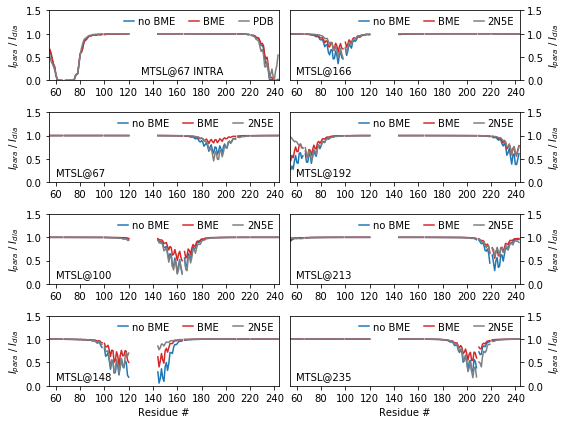

In [21]:
fig, axes = plt.subplots(4, 2, sharex=False, sharey=False, figsize=(8,6))

label = 67
resnums, PREratios, PRErates = np.loadtxt('calcPRE/res-{:d}.dat'.format(label),unpack=True)
axes[0,0].plot(resnums,PREratios,color=plt.cm.tab10(0),label='no BME')
resnums, PREratios, PRErates = np.loadtxt('calcPRE/BMEres-{:d}.dat'.format(label),unpack=True)
axes[0,0].plot(resnums,PREratios,color=plt.cm.tab10(3),label='BME')
resnums, PREratios, PRErates = np.loadtxt('calcPRE/PDBres-{:d}.dat'.format(label),unpack=True)
axes[0,0].plot(resnums,PREratios,color=plt.cm.tab10(7),label='PDB')

axes[0,0].legend(frameon=False,handlelength=1,ncol=4,loc='upper right',borderpad=.1,
                columnspacing=1.4,handletextpad=.4)
axes[0,0].annotate('MTSL@{:d} INTRA'.format(label),xy=(.4,.1),xycoords='axes fraction')
axes[0,0].set_xlim(54,244)
axes[0,0].set_ylim(0,1.5)
axes[0,0].set_xticks(range(60,241,20))
axes[0,0].set_ylabel('$I_{para}$ / $I_{dia}$')

labels = [166,67,192,100,213,148,235]
for ax,label in zip(axes.flatten()[1:],labels):

    resnums, PREratiosAB, _ = np.loadtxt('calcPRE/ABres-{:d}.dat'.format(label),unpack=True)
    resnums, PREratiosBA, _ = np.loadtxt('calcPRE/BAres-{:d}.dat'.format(label),unpack=True)
    PREratios = (PREratiosAB+PREratiosBA)/2
    ax.plot(resnums,PREratios,color=plt.cm.tab10(0),label=r'no BME')
    resnums, PREratiosAB, _ = np.loadtxt('calcPRE/BMEABres-{:d}.dat'.format(label),unpack=True)
    resnums, PREratiosBA, _ = np.loadtxt('calcPRE/BMEBAres-{:d}.dat'.format(label),unpack=True)
    PREratios = (PREratiosAB+PREratiosBA)/2
    ax.plot(resnums,PREratios,color=plt.cm.tab10(3),label=r'BME')
    resnums, PREratiosAB, _ = np.loadtxt('calcPRE/PDBABres-{:d}.dat'.format(label),unpack=True)
    resnums, PREratiosBA, _ = np.loadtxt('calcPRE/PDBBAres-{:d}.dat'.format(label),unpack=True)
    PREratios = (PREratiosAB+PREratiosBA)/2
    ax.plot(resnums,PREratios,color=plt.cm.tab10(7),label=r'2N5E')

    ax.set_ylabel('$I_{para}$ / $I_{dia}$')
    ax.legend(frameon=False,handlelength=1,ncol=4,loc='upper right',borderpad=.1,columnspacing=1.4,handletextpad=.4)
    
    ax.annotate('MTSL@{:d}'.format(label),xy=(.03,.1),xycoords='axes fraction')
    
    ax.set_xlim(54,244)
    ax.set_xticks(range(60,241,20))
    
    ax.set_ylim(0,1.5)
    
for i in [1,3,5,7]:
    axes.flatten()[i].yaxis.set_label_position("right")
    axes.flatten()[i].yaxis.set_ticks_position('right')
    
axes.flatten()[-2].set_xlabel('Residue #')
axes.flatten()[-1].set_xlabel('Residue #')

plt.tight_layout(w_pad=.5)
plt.savefig('Fig2_S5.pdf')